## Importing necessary libraries

In [7]:
from cadv_exploration.loader import FileLoader
from cadv_exploration.utils._utils import get_project_root
from cadv_exploration.utils.data_class import Constraints

## initializing the project root and the path to the data

In [8]:
project_root = get_project_root()
local_project_path = project_root / 'data' / 'playground-series-s4e10'
train_file_path = local_project_path / "files_with_clean_test_data" / "train.csv"
constraints_output_path = local_project_path / 'output'
deequ_constraints = Constraints.from_yaml(input_path=constraints_output_path / 'deequ_constraints.yaml')
cadv_constraints_dict = {}
for cadv_output_path in constraints_output_path.iterdir():
    if cadv_output_path.is_dir():
        cadv_constraints = Constraints.from_yaml(input_path=cadv_output_path / 'cadv_constraints.yaml')
        cadv_constraints_dict[cadv_output_path.name] = cadv_constraints

In [9]:
train_data = FileLoader.load_csv(train_file_path)
all_column_names = list(train_data.columns)

## Plotting the distribution of the constraints

In [10]:
def get_suggestion_frequency(constraints: Constraints, all_column_names: list):
    suggestion_frequency = {column_name: (0, 0) for column_name in all_column_names}
    for column_name in constraints.constraints.keys():
        valid_suggestion_frequency = sum([c.validity == "Valid" for c in constraints.constraints[column_name].code])
        invalid_suggestion_frequency = sum([c.validity == "Invalid" for c in constraints.constraints[column_name].code])
        suggestion_frequency[column_name] = (valid_suggestion_frequency, invalid_suggestion_frequency)
    return suggestion_frequency

In [11]:
deequ_suggestion_frequency = get_suggestion_frequency(deequ_constraints, all_column_names)
cadv_suggestion_frequency_dict = {}
for script_name, cadv_constraints in cadv_constraints_dict.items():
    cadv_suggestion_frequency_dict[script_name] = get_suggestion_frequency(cadv_constraints, all_column_names)

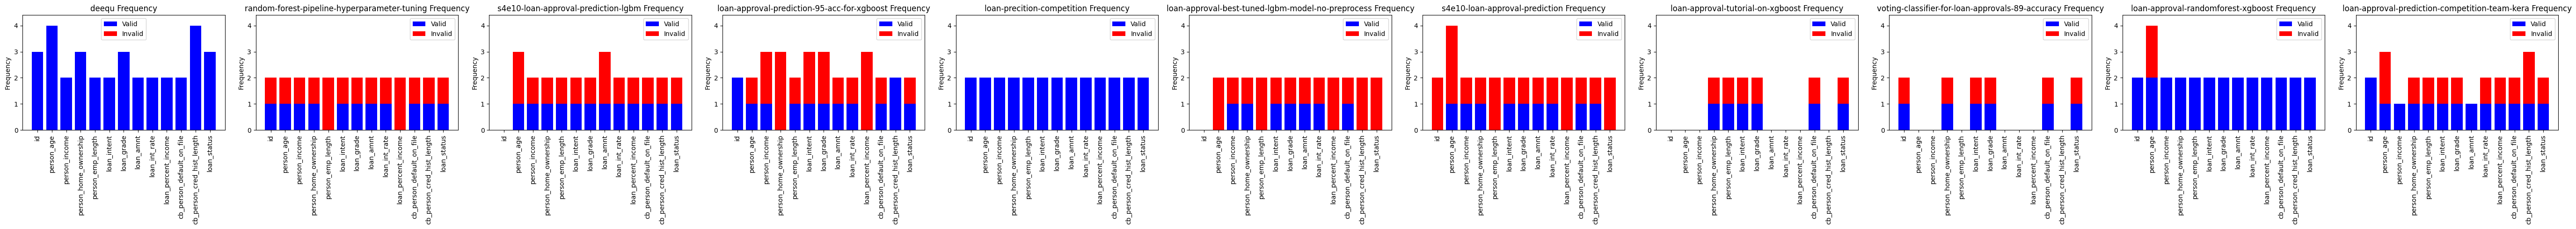

In [12]:
import matplotlib.pyplot as plt


def plot_suggestion_frequency(ax, suggestion_frequency: dict, ylim=None):
    """
    Plot a single suggestion frequency stacked bar chart.
    """
    # Separate valid and invalid frequencies
    column_names = list(suggestion_frequency.keys())
    valid_frequencies = [freq[0] for freq in suggestion_frequency.values()]
    invalid_frequencies = [freq[1] for freq in suggestion_frequency.values()]

    # Bar positions
    x = range(len(column_names))

    # Plot stacked bars
    ax.bar(x, valid_frequencies, label='Valid', color='blue')
    ax.bar(x, invalid_frequencies, bottom=valid_frequencies, label='Invalid', color='red')

    ylim = max(valid_frequencies + invalid_frequencies) * 1.1 if ylim is None else ylim

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(column_names, rotation=90)
    ax.set_ylabel('Frequency')
    ax.set_ylim(0, ylim)
    ax.set_title('Suggestion Frequency')
    ax.legend()


def plot_suggestion_frequencies(**suggestion_frequency_dict):
    """
    Plot multiple suggestion frequency charts in subplots.
    """
    num_plots = len(suggestion_frequency_dict)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # 1 row, num_plots columns

    # Ensure axes is iterable even for a single plot
    if num_plots == 1:
        axes = [axes]

    ylim = max([max([freq[0] + freq[1] for freq in suggestion_frequency.values()]) for suggestion_frequency in
                suggestion_frequency_dict.values()]) * 1.1

    # Loop through data and axes
    for ax, (script_name, suggestion_frequency) in zip(axes, suggestion_frequency_dict.items()):
        plot_suggestion_frequency(ax, suggestion_frequency, ylim)
        ax.set_title(f'{script_name} Frequency')

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_suggestion_frequencies(deequ=deequ_suggestion_frequency, **cadv_suggestion_frequency_dict)

## New plot